# Watershed segmentation for cell identification

In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

import cv2

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

### Read image

Read image as greyscale and color in parallel

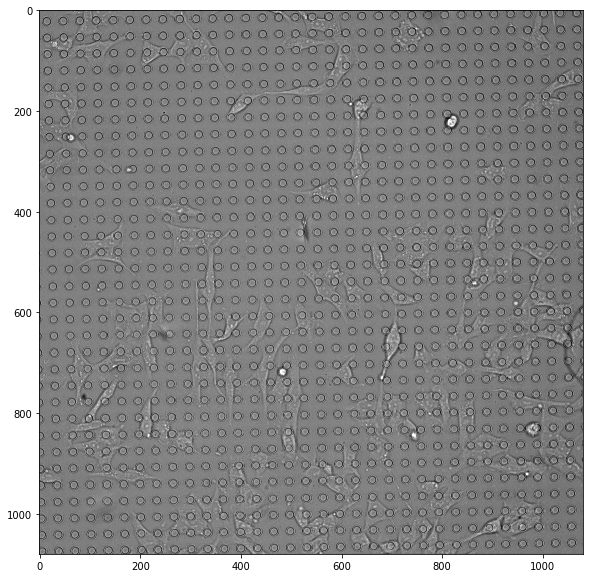

In [2]:
image_file = cv2.imread('/Users/carolinemccue/Desktop/MG63/r01c03f60p02-ch2sk1fk1fl1.jpg',0)
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(image_file, cmap=plt.cm.gray, interpolation='nearest')

plt.show()

In [3]:
image_file

array([[159, 161, 163, ..., 156, 151, 154],
       [163, 163, 164, ..., 160, 154, 155],
       [161, 162, 163, ..., 160, 147, 157],
       ...,
       [168, 187, 176, ..., 162, 161, 161],
       [147, 185, 184, ..., 160, 163, 162],
       [120, 165, 182, ..., 155, 156, 159]], dtype=uint8)

### convert to uint (for some skimage methods)

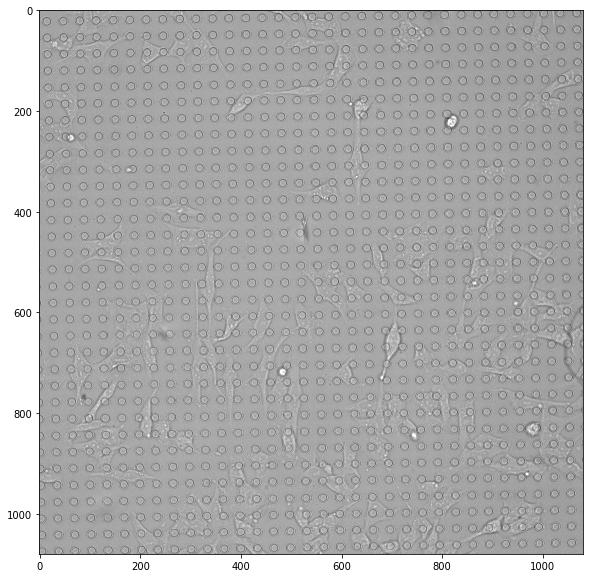

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(image_file, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')
plt.show()

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

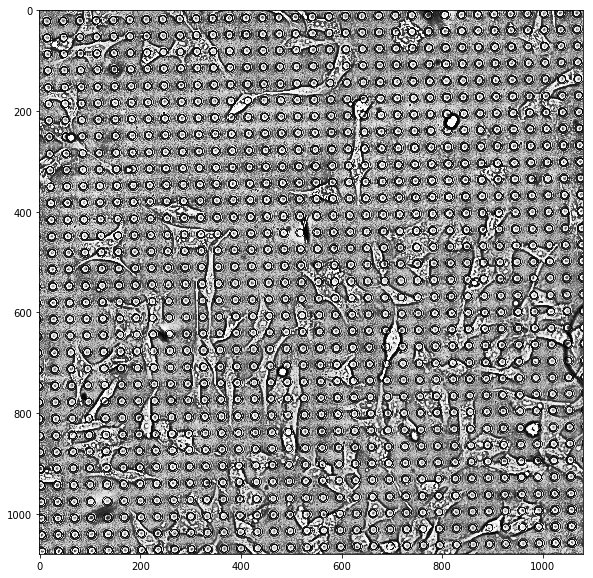

In [39]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=30, tileGridSize=(10,10))
img_adapteq = clahe.apply(image_file)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

### Threshold

Otsu threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 123.0
Min intensity: 0
Max intensity: 255


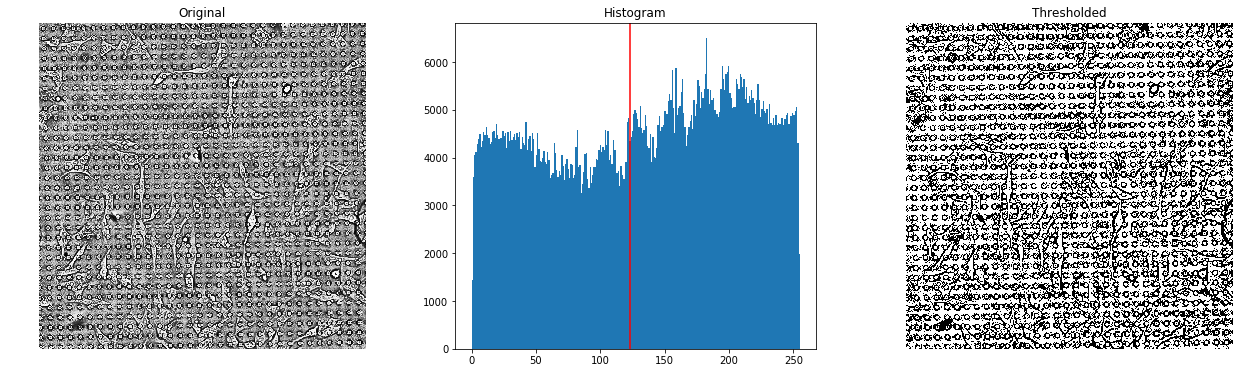

In [40]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Detect sure foreground and background from thresholding and distance transform
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

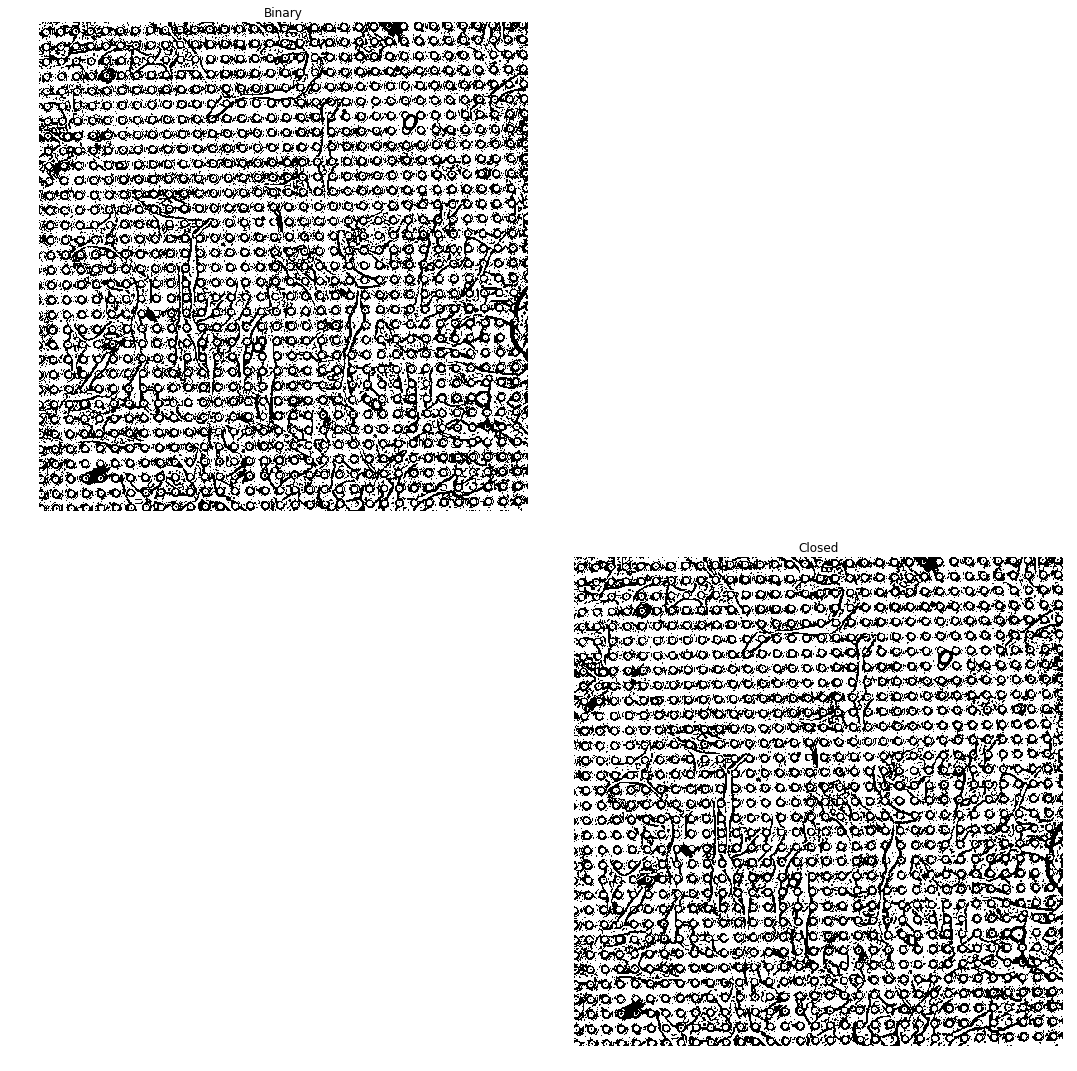

In [41]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 85)
#remove_posts = morphology.remove_small_holes(remove_posts, 85)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

#### Sure foreground / background determination

In [42]:
def clear_border(image):
    h, w = image.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    for i in range(h-1): # Iterate on the lines
        if image[i, 0] == 255:
            cv2.floodFill(image, mask, (0, i), 0)
        if image[i, w-1] == 255:
            cv2.floodFill(image, mask, (w-1, i), 0)
    for i in range(w-1): # Iterate on the columns
        if image[0, i] == 255:
            cv2.floodFill(image, mask, (i, 0), 0)
        if image[h-1, i] == 255:
            cv2.floodFill(image, mask, (i, h-1), 0)
    return image

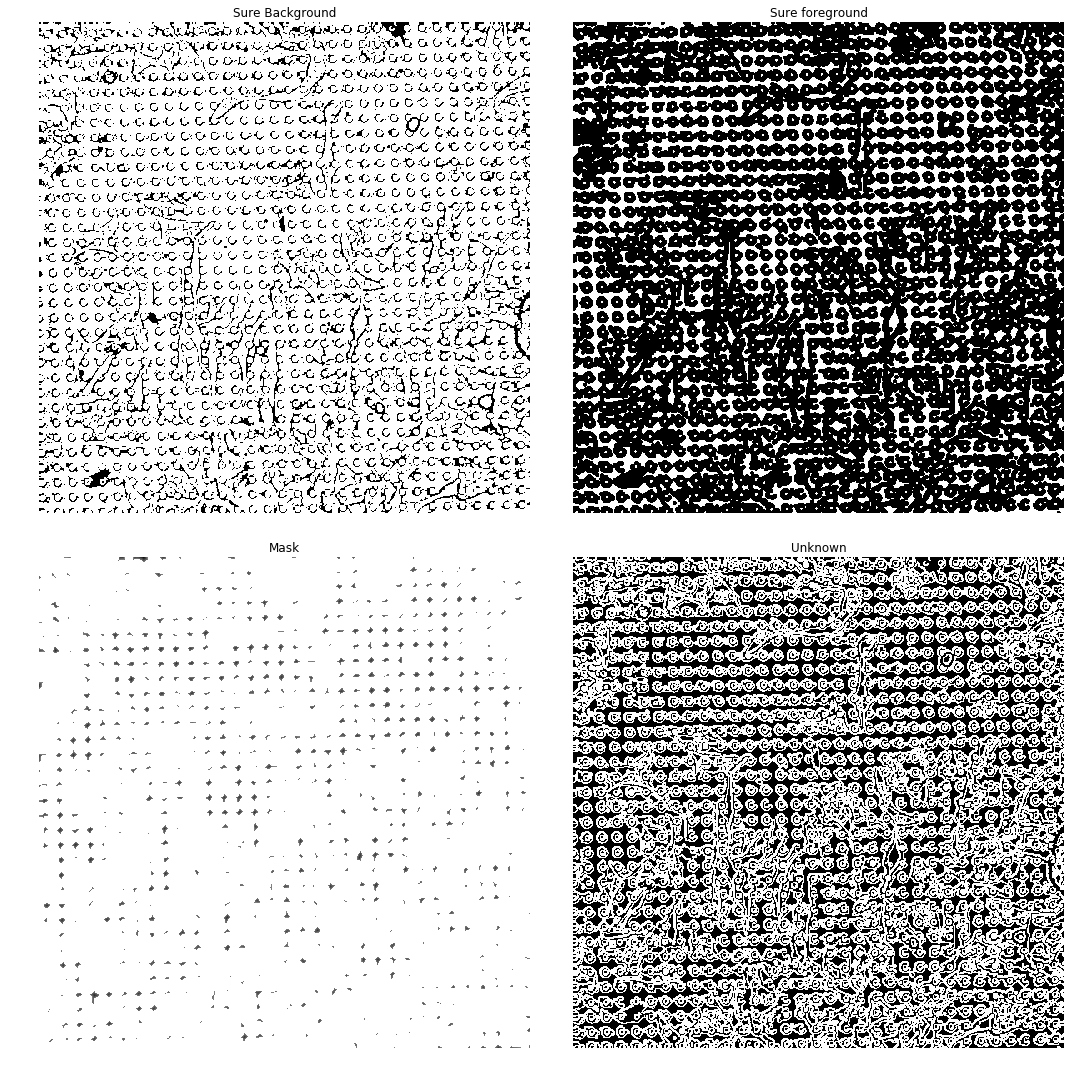

In [73]:
# Alternative thresholding
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=2)
sure_bg = cv2.dilate(closing,kernel,iterations=2)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Label markers

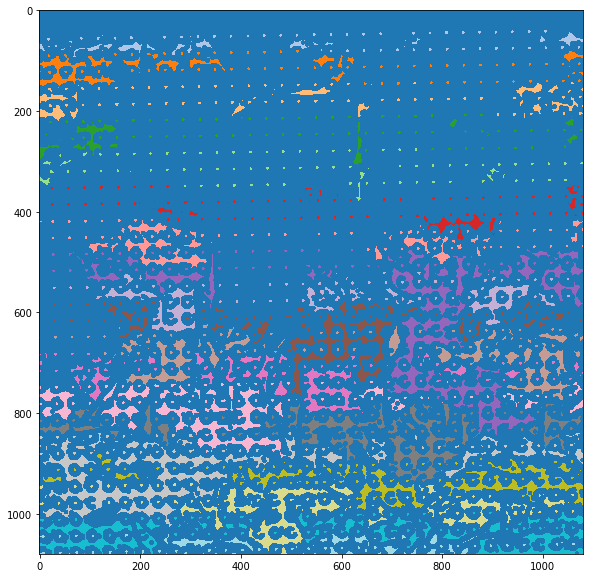

In [74]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
#markers = markers+1

# Now, mark the region of unknown with zero
#markers[unknown>0] = 0

fig = plt.figure(figsize=(15,10))
plt.imshow(markers, cmap=plt.cm.tab20)

#### Run the watershed algorithm

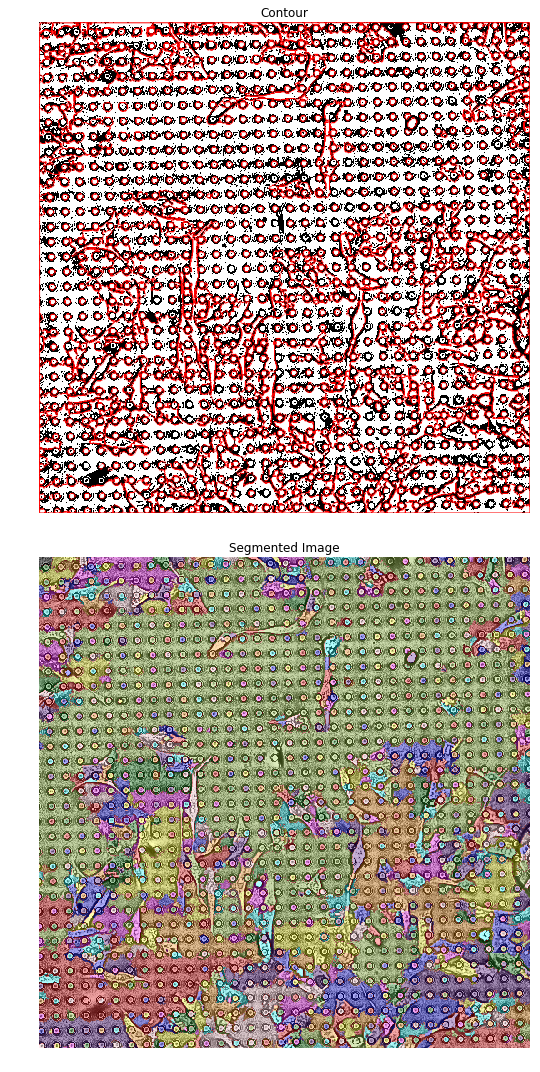

In [75]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image=img_adapteq, bg_label=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[0].contour(segmented, [0.5], linewidths=1, colors='r')
ax[0].set_title('Contour')
ax[1].imshow(image_label_overlay)
ax[1].set_title('Segmented Image')

for a in ax:
    a.set_axis_off()

    
plt.tight_layout()
plt.show()

#### Extract the region properties

Note that label 1 is attributed to the background in the code above

In [76]:
reg = regionprops(segmented, intensity_image=image_file)[1:]
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg])
df.head(5)

Label    Area  Eccentricity  Circularity  Bbox Area               Bbox  \
0    2.0   641.0      0.935780     0.277984  1166400.0    (1, 28, 29, 87)   
1    3.0  7860.0      0.929817     0.074965  1166400.0  (1, 109, 76, 317)   
2    4.0   912.0      0.798887     0.193001  1166400.0  (1, 236, 35, 297)   
3    5.0   543.0      0.634049     0.441960  1166400.0  (1, 286, 28, 322)   
4    6.0   175.0      0.965665     0.250676  1166400.0  (1, 343, 17, 387)   

                                   Centroid  \
0    (8.678627145085803, 48.58970358814353)   
1   (34.70508905852417, 208.09020356234097)   
2  (13.894736842105264, 268.41008771929825)   
3   (9.955801104972375, 302.69613259668506)   
4   (4.0685714285714285, 358.0857142857143)   

                                               Image  
0  [[0, 0, 162, 160, 162, 163, 162, 163, 164, 162...  
1  [[0, 0, 0, 0, 0, 0, 0, 181, 184, 177, 169, 165...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[146, 145, 154, 162, 165, 164, 162, 163, 168,...  
4  [[168, 168, 167, 166, 166, 169, 171, 175, 173,...

#### Display labeled region bounding boxes and labels

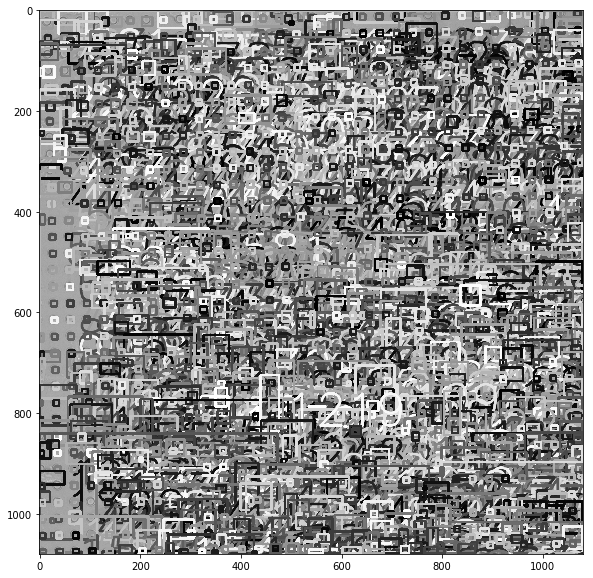

In [77]:
boxed_regions = image_file.copy()

# Iterate over all non-background labels
for region in reg:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

#### Evaluate peo

In [ ]:
df[df['Label'] == 100]

In [ ]:
df.Circularity.plot()

In [ ]:
df.Eccentricity.plot()

(109.0, 651.8853349426674, 977.8280024140012)

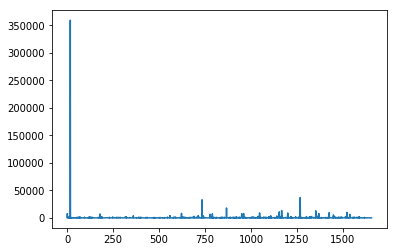

In [78]:
df['Area'].plot()
df['Area'].median(), df['Area'].mean(), 1.5*df['Area'].mean()

In [ ]:
plt.hist(df.Area,100)

In [ ]:
plt.scatter(df.Eccentricity,df["Area"])

In [ ]:
plt.scatter(df.Eccentricity,df["Bbox Area"])

1657 cells were detected and segmented
270 cells with selected criteria


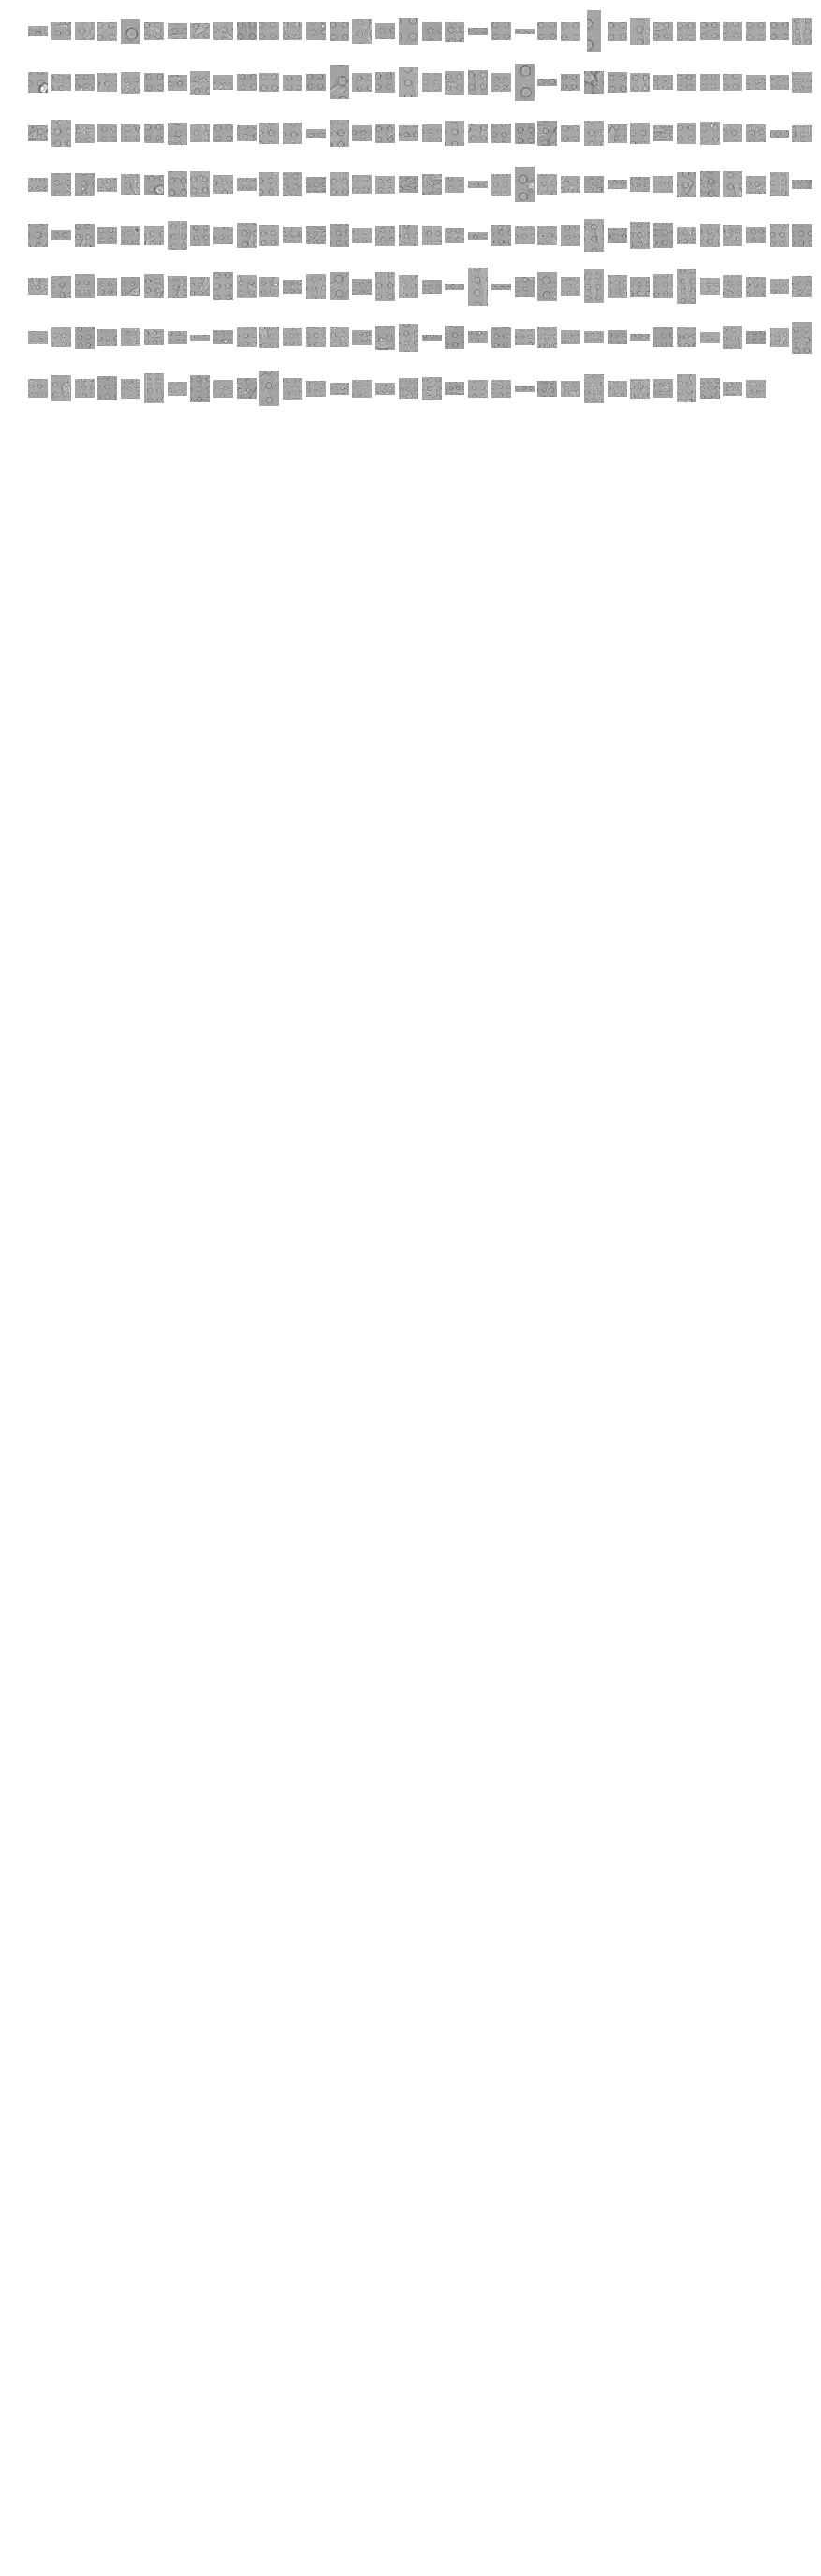

In [81]:
# Display parameters
org_img = image_file # Intensity image
border = 35 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.25 # circularity cuttoff, removes background circles
area_cutoff_upper = 1.5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 2.5*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(reg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

reg.sort(key=lambda x: x.area)
reg_clean = [region for region in reg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff]

print("{} cells with selected criteria".format(len(reg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)



In [80]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg_clean])
df2.head(15)

Label   Area  Eccentricity  Circularity  Bbox Area                  Bbox  \
0     28.0  273.0      0.636506     0.495014  1166400.0      (1, 90, 26, 106)   
1   1467.0  273.0      0.904618     0.350149  1166400.0  (962, 774, 989, 805)   
2    474.0  274.0      0.723817     0.420424  1166400.0  (316, 627, 338, 653)   
3    990.0  274.0      0.596117     0.618737  1166400.0  (662, 453, 685, 473)   
4     64.0  275.0      0.766014     0.496519  1166400.0       (17, 1, 36, 27)   
5   1310.0  276.0      0.699583     0.716021  1166400.0  (868, 291, 885, 315)   
6    134.0  277.0      0.875183     0.550786  1166400.0    (61, 125, 80, 155)   
7    344.0  277.0      0.802738     0.221368  1166400.0  (204, 397, 224, 427)   
8   1223.0  277.0      0.885847     0.601328  1166400.0  (811, 725, 834, 750)   
9     70.0  278.0      0.875033     0.201397  1166400.0  (17, 1027, 50, 1047)   
10   537.0  279.0      0.765398     0.728877  1166400.0  (376, 183, 393, 205)   
11   806.0  279.0      0.677960     0.790482  1166400.0  (565, 580, 584, 603)   
12   893.0  280.0      0.778269     0.686383  1166400.0  (605, 930, 625, 955)   
13   316.0  282.0      0.424332     0.920646  1166400.0  (177, 175, 195, 194)   
14   952.0  282.0      0.853681     0.398889  1166400.0  (639, 206, 672, 224)   

                                    Centroid  \
0    (10.062271062271062, 97.55311355311355)   
1     (975.1025641025641, 787.2967032967033)   
2     (325.7335766423358, 638.1386861313869)   
3    (674.4233576642335, 462.82481751824815)   
4   (24.927272727272726, 13.829090909090908)   
5    (876.2101449275362, 301.81159420289856)   
6    (68.78339350180505, 137.70036101083033)   
7   (213.63537906137185, 409.14440433212997)   
8     (823.1299638989169, 736.2779783393502)   
9   (33.093525179856115, 1034.2158273381294)   
10   (383.36917562724017, 193.2652329749104)   
11     (572.899641577061, 589.7383512544803)   
12    (613.9357142857143, 942.6964285714286)   
13  (185.11347517730496, 183.68085106382978)   
14   (656.1914893617021, 215.13120567375887)   

                                                Image  
0   [[0, 177, 172, 166, 166, 171, 162, 158, 157, 1...  
1   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2   [[0, 0, 0, 0, 0, 0, 180, 182, 176, 168, 0, 0, ...  
3   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 165, ...  
4   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 172...  
5   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 117, 1...  
6   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16...  
7   [[0, 0, 0, 0, 0, 0, 0, 170, 172, 0, 0, 0, 0, 0...  
8   [[0, 0, 0, 0, 0, 176, 170, 164, 0, 0, 0, 0, 0,...  
9   [[0, 0, 0, 158, 160, 158, 0, 0, 0, 0, 0, 0, 0,...  
10  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
11  [[0, 0, 152, 151, 137, 131, 131, 0, 0, 0, 122,...  
12  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 173, 0...  
13  [[0, 0, 156, 129, 0, 124, 137, 143, 146, 146, ...  
14  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, ...

In [ ]:
boxed_regions = image_file.copy()
for region in reg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [ ]:
df2.Circularity.plot()

In [ ]:
df2.Eccentricity.plot()

In [ ]:
df2.Area.plot()
df2['Area'].median(), df2['Area'].mean()

In [ ]:
plt.scatter(df2.Eccentricity,df2["Area"])

In [ ]:
plt.hist(df2.Area,150)
plt.xlabel("Cell Area")
plt.ylabel("Frequency")
plt.title("Cell Area Distribution")

In [ ]:
plt.hist(df2.Eccentricity,150)
plt.xlabel("Cell Eccentricity")
plt.ylabel("Frequency")
plt.title("Cell Eccentricity Distribution")